In [1]:
# !pip install  scikit-learn pandas matplotlib tqdm gradio
# !pip install kagglehub
# !pip install torch torchvision
# !pip install opencv-python

In [2]:
# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder, ImageFolder

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Misc
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub
from PIL import Image

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Function to find imaghes because I have a custom folder structure that is hard to load directly
def find_images(folder_path, label):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            images.append((os.path.join(folder_path, file), label))
    return images

data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v2")
print("Downloaded at:", data_dir)

# Point to the actual subfolder that contains glaucoma/ and normal/ because the dataset is nested with folders
data_dir = os.path.join(data_dir, "Glaucoma Dataset for AI Diagnosis")
print("Current Data Dir:", data_dir)
print("Top-Level Folders:", os.listdir(data_dir))

glaucoma_images = find_images(os.path.join(data_dir, "glaucoma"), 1)
normal_images = find_images(os.path.join(data_dir, "normal"), 0)

all_images = glaucoma_images + normal_images

# Stratified splits: train=596, test=50, val=100
from sklearn.model_selection import train_test_split

# First split: separate test set (50 samples)
train_val_idx, test_idx = train_test_split(
    range(len(all_images)),
    test_size=50,
    stratify=[label for _, label in all_images],
    random_state=42
)

# Second split: separate train and val from remaining data
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=100,
    stratify=[all_images[i][1] for i in train_val_idx],
    random_state=42
)

train_split = [all_images[i] for i in train_idx]
val_split = [all_images[i] for i in val_idx]
test_split = [all_images[i] for i in test_idx]

print("Train samples:", len(train_split))
print("Val samples:", len(val_split))
print("Test samples:", len(test_split))

# Save split information to CSV files
import pandas as pd

# Create DataFrames for train, val, and test splits
train_df = pd.DataFrame(train_split, columns=['image_path', 'label'])
val_df = pd.DataFrame(val_split, columns=['image_path', 'label'])
test_df = pd.DataFrame(test_split, columns=['image_path', 'label'])

# Save to CSV files
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print(f"Saved train split to train_split.csv ({len(train_df)} images)")
print(f"Saved val split to val_split.csv ({len(val_df)} images)")
print(f"Saved test split to test_split.csv ({len(test_df)} images)")

Downloaded at: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1
Current Data Dir: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1\Glaucoma Dataset for AI Diagnosis
Top-Level Folders: ['glaucoma', 'normal']
Train samples: 3009
Val samples: 100
Test samples: 50
Saved train split to train_split.csv (3009 images)
Saved val split to val_split.csv (100 images)
Saved test split to test_split.csv (50 images)


In [4]:
# Custom dataset class I creasted to traverse the custom folder structure properly
class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmented transform for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Simpler transform for validation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_split, transform=train_transform)
val_dataset = CustomDataset(val_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [5]:
# Load the pre-trained MobileNetV3 model so I can train it on my custom dataset
model = models.mobilenet_v3_large(pretrained=True)

model.classifier[2] = nn.Dropout(p=0.4)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
EPOCHS = 30
PATIENCE = 5 # Early stopping patience, I need this because my model overfits quickly and easily on my dataset even after augmenting it

# These next four lines were so I could make graphs for training and validation losses and accuracies
# I don't need to change these, but I will leave them here for reference
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Store epoch-wise predictions for metrics
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
        f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
        print("New best model found (val_loss improved).")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")

Epoch 1/30: 100%|██████████| 95/95 [02:19<00:00,  1.47s/it]



Epoch 1: Train Loss = 0.1948, Train Acc = 90.93% | Val Loss = 0.4218, Val Acc = 86.00%
New best model found (val_loss improved).


Epoch 2/30: 100%|██████████| 95/95 [02:03<00:00,  1.30s/it]



Epoch 2: Train Loss = 0.1150, Train Acc = 94.58% | Val Loss = 0.2800, Val Acc = 93.00%
New best model found (val_loss improved).


Epoch 3/30: 100%|██████████| 95/95 [01:58<00:00,  1.24s/it]



Epoch 3: Train Loss = 0.0978, Train Acc = 95.45% | Val Loss = 0.4199, Val Acc = 82.00%


Epoch 4/30: 100%|██████████| 95/95 [01:58<00:00,  1.25s/it]



Epoch 4: Train Loss = 0.0808, Train Acc = 96.41% | Val Loss = 0.1512, Val Acc = 94.00%
New best model found (val_loss improved).


Epoch 5/30: 100%|██████████| 95/95 [01:58<00:00,  1.25s/it]



Epoch 5: Train Loss = 0.0748, Train Acc = 96.48% | Val Loss = 0.1855, Val Acc = 92.00%


Epoch 6/30: 100%|██████████| 95/95 [01:59<00:00,  1.26s/it]



Epoch 6: Train Loss = 0.0707, Train Acc = 96.91% | Val Loss = 0.2116, Val Acc = 91.00%


Epoch 7/30: 100%|██████████| 95/95 [01:59<00:00,  1.26s/it]



Epoch 7: Train Loss = 0.0622, Train Acc = 97.24% | Val Loss = 0.1495, Val Acc = 95.00%
New best model found (val_loss improved).


Epoch 8/30: 100%|██████████| 95/95 [01:58<00:00,  1.25s/it]



Epoch 8: Train Loss = 0.1217, Train Acc = 98.27% | Val Loss = 0.0972, Val Acc = 97.00%
New best model found (val_loss improved).


Epoch 9/30: 100%|██████████| 95/95 [02:02<00:00,  1.29s/it]



Epoch 9: Train Loss = 0.0481, Train Acc = 97.97% | Val Loss = 0.0603, Val Acc = 98.00%
New best model found (val_loss improved).


Epoch 10/30: 100%|██████████| 95/95 [01:58<00:00,  1.25s/it]



Epoch 10: Train Loss = 0.0352, Train Acc = 98.74% | Val Loss = 0.1130, Val Acc = 97.00%


Epoch 11/30: 100%|██████████| 95/95 [02:00<00:00,  1.26s/it]



Epoch 11: Train Loss = 0.0387, Train Acc = 98.54% | Val Loss = 0.0595, Val Acc = 98.00%
New best model found (val_loss improved).


Epoch 12/30: 100%|██████████| 95/95 [01:57<00:00,  1.24s/it]



Epoch 12: Train Loss = 0.0249, Train Acc = 99.14% | Val Loss = 0.1257, Val Acc = 96.00%


Epoch 13/30: 100%|██████████| 95/95 [01:49<00:00,  1.16s/it]



Epoch 13: Train Loss = 0.0326, Train Acc = 98.67% | Val Loss = 0.0930, Val Acc = 97.00%


Epoch 14/30: 100%|██████████| 95/95 [01:49<00:00,  1.16s/it]



Epoch 14: Train Loss = 0.0235, Train Acc = 99.07% | Val Loss = 0.1179, Val Acc = 97.00%


Epoch 15/30: 100%|██████████| 95/95 [01:50<00:00,  1.16s/it]



Epoch 15: Train Loss = 0.0164, Train Acc = 99.27% | Val Loss = 0.0811, Val Acc = 97.00%


Epoch 16/30: 100%|██████████| 95/95 [01:53<00:00,  1.20s/it]



Epoch 16: Train Loss = 0.0197, Train Acc = 99.34% | Val Loss = 0.1474, Val Acc = 95.00%
Early stopping triggered.


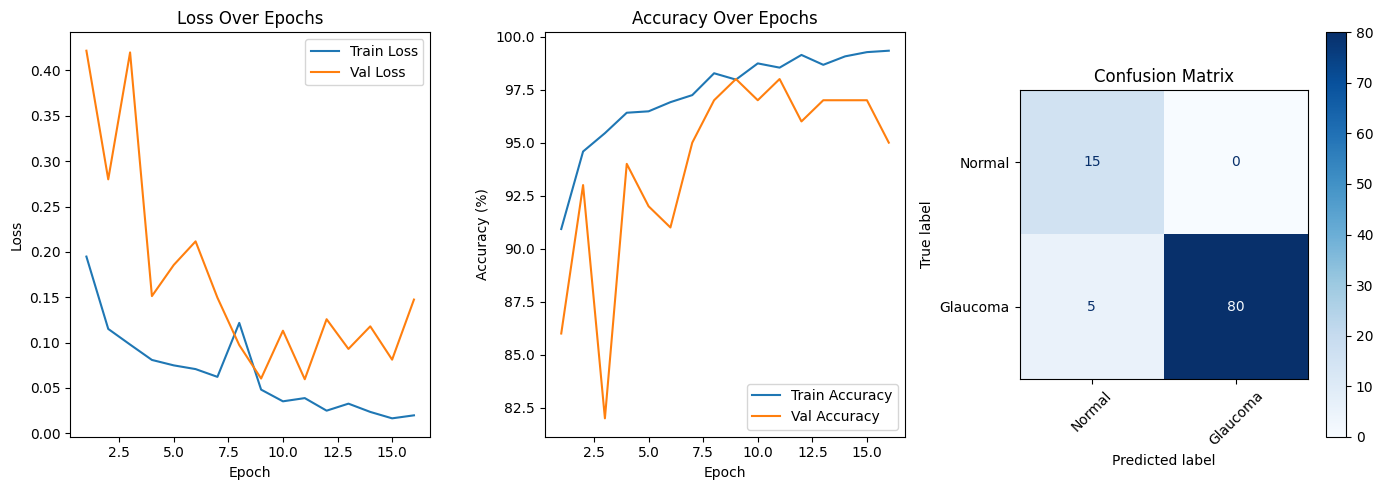

In [7]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(epoch_val_labels, epoch_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("glaucoma_results.png")
plt.show()

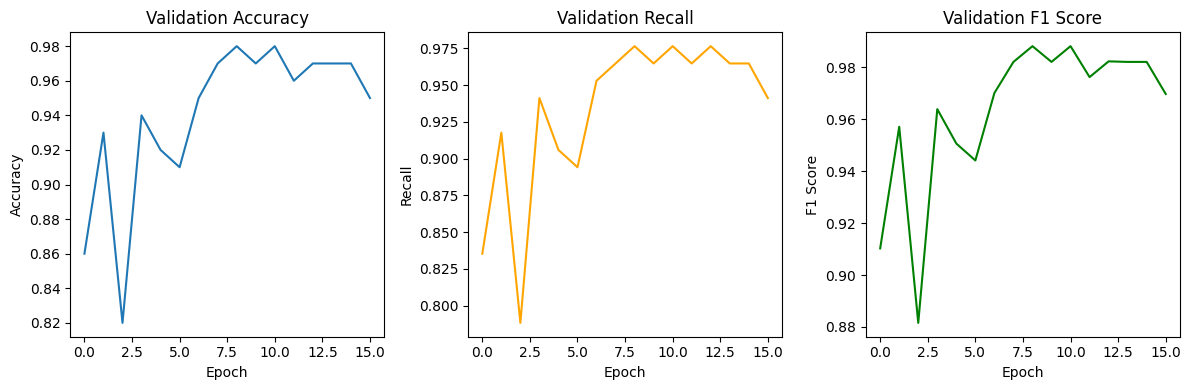

In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for epoch_preds, epoch_labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(epoch_labels, epoch_preds))
    val_metrics["recall"].append(recall_score(epoch_labels, epoch_preds))
    val_metrics["f1_score"].append(f1_score(epoch_labels, epoch_preds))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.plot(val_metrics["recall"], label="Recall", color="orange")
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")

plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


=== FINAL TEST SET RESULTS ===
Test Accuracy: 0.9800 (98.00%)
Test Precision: 0.9822
Test Recall: 0.9800
Test F1-Score: 0.9805

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94         8
    Glaucoma       1.00      0.98      0.99        42

    accuracy                           0.98        50
   macro avg       0.94      0.99      0.96        50
weighted avg       0.98      0.98      0.98        50



<Figure size 800x600 with 0 Axes>

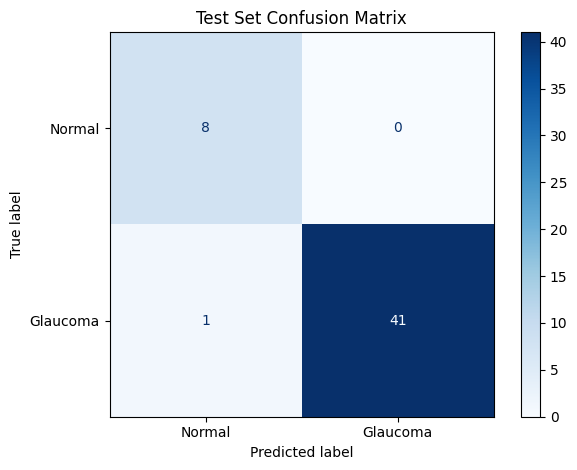

In [9]:
# Test Set Evaluation
print("Evaluating on test set...")

# Create test dataset and loader
test_dataset = CustomDataset(test_split, transform=val_transform)  # Use same transform as validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Evaluate on test set
model.eval()
test_correct, test_total = 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total

# Calculate test metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"\n=== FINAL TEST SET RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_acc:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Normal", "Glaucoma"]))

# Test confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(test_labels, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normal", "Glaucoma"])
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.savefig("test_confusion_matrix.png")
plt.show()

=== MODEL PERFORMANCE SUMMARY ===

Performance Summary:
Dataset      Accuracy   Recall     F1-Score  
---------------------------------------------
Training     0.9934     -          -         
Validation   0.9500     0.9412     0.9697    
Test         0.9800     0.9800     0.9805    

Summary saved to model_performance_summary.csv


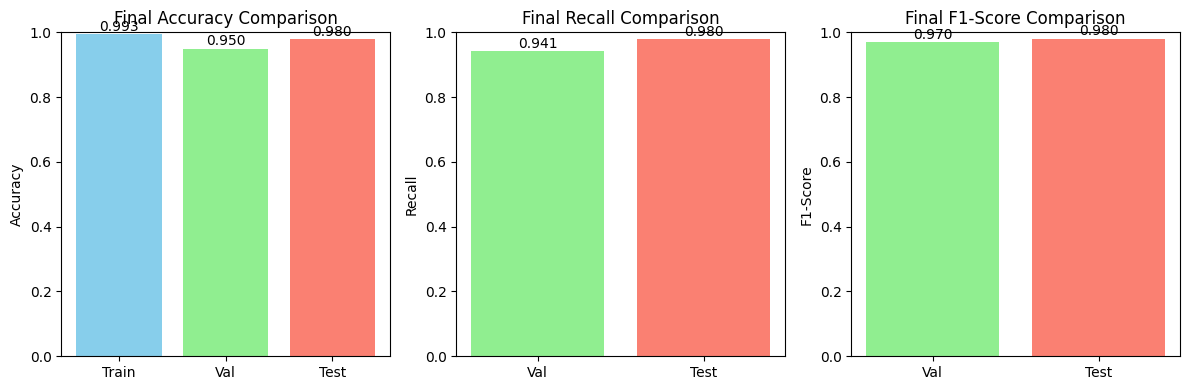

In [11]:
# Summary Comparison: Train vs Validation vs Test
print("=== MODEL PERFORMANCE SUMMARY ===")

# Get final training metrics (last epoch)
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]

# Get final validation metrics
final_val_accuracy = val_metrics["accuracy"][-1]
final_val_recall = val_metrics["recall"][-1]
final_val_f1 = val_metrics["f1_score"][-1]

# Create summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [final_train_acc/100, final_val_accuracy, test_accuracy],
    'Recall': ['-', final_val_recall, test_recall],
    'F1-Score': ['-', final_val_f1, test_f1]
}

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")

# Format and print the table manually to avoid pandas formatting issues
print(f"{'Dataset':<12} {'Accuracy':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 45)
for idx, row in summary_df.iterrows():
    dataset = row['Dataset']
    accuracy = f"{row['Accuracy']:.4f}" if isinstance(row['Accuracy'], (int, float)) else row['Accuracy']
    recall = f"{row['Recall']:.4f}" if isinstance(row['Recall'], (int, float)) else row['Recall']
    f1_score = f"{row['F1-Score']:.4f}" if isinstance(row['F1-Score'], (int, float)) else row['F1-Score']
    print(f"{dataset:<12} {accuracy:<10} {recall:<10} {f1_score:<10}")

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print(f"\nSummary saved to model_performance_summary.csv")

# Plot final comparison
plt.figure(figsize=(12, 4))

# Accuracy comparison
plt.subplot(1, 3, 1)
datasets = ['Train', 'Val', 'Test']
accuracies = [final_train_acc/100, final_val_accuracy, test_accuracy]
bars1 = plt.bar(datasets, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Recall comparison
plt.subplot(1, 3, 2)
recall_vals = [final_val_recall, test_recall]
bars2 = plt.bar(['Val', 'Test'], recall_vals, color=['lightgreen', 'salmon'])
plt.title('Final Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
for i, v in enumerate(recall_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-Score comparison
plt.subplot(1, 3, 3)
f1_vals = [final_val_f1, test_f1]
bars3 = plt.bar(['Val', 'Test'], f1_vals, color=['lightgreen', 'salmon'])
plt.title('Final F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('final_performance_comparison.png')
plt.show()